<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/5.1-LSTM-misclassification-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miscategorized Reviews by LSTM

In previous notebooks, we filtered and trained LSTM network with 16 nodes based on original sample size of 1 million samples

Variations and links to notebooks:


* [1 and 5 star ratings](deep_learning/6.6.3.2-LSTMB16_15-GloVe_with_stop_nonlemmatized-1m-prototype.ipynb)
* [1, 4, 5 star ratings](deep_learning/6.7.3.2-LSTMB16_145-GloVe_with_stop_nonlemmatized-1m-prototype.ipynb)
* [1, 3, 4, 5 star ratings](deep_learning/6.8.3.2-LSTMB16_1345-GloVe_with_stop_nonlemmatized-1m-prototype.ipynb)
* [All star ratings](deep_learning/6.5.3.2-LSTMB16-GloVe_with_stop_nonlemmatized-1m-prototype.ipynb)

In this notebook, we will look at the model performance as well as look at specific reviews that were miscategorized

For specifics, see [debugging the model](#model-debugging) section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 2.x selected.


''

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import json
from pprint import pprint


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=1.5)


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False

pd.set_option("max_colwidth", 300)
REPORT_FILE = f'{DRIVE_DIR}/reports/glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv'

# set to True if you want to re-created out of vocab list and comprehensive dataframe from scratch
FORCE_LOAD = False

Read in report file

In [0]:
report = pd.read_csv(REPORT_FILE, quotechar="'")
report["train_examples"] = report.train_examples.astype(int)
# 1-star and 5-star only
lstm_15 = report[report.model_name == "LSTMB16_15"].copy().reset_index()
# 1-star, 4-star, and 5-star
lstm_145 = report[report.model_name == "LSTMB16_145"].copy().reset_index()
# 1-star, 3-star, 4-star, and 5-star
lstm_1345 = report[report.model_name == "LSTMB16_1345"].copy().reset_index()
# all reviews
lstm_all = report[report.model_name == "LSTMB16"].copy().reset_index()

# all training used the same base sample file so we will just load one
data_file = lstm_15.file.values[0]

# Fix Classification Report For Various Runs

Have to remap classes from classification to the real class labels

In [0]:
# map 2->5
cr15 = json.loads(lstm_15.classification_report.values[0])
cr15["5"] = cr15.pop("2")
lstm_15.loc[lstm_15.index, "classification_report"] = json.dumps(cr15)
lstm_15["label"] = "1,5 Star"
lstm_15 = ru.convert_dnn_report_format(lstm_15)

# map 3->5, 2->4
cr145 = json.loads(lstm_145.classification_report.values[0])
cr145["5"] = cr145.pop("3")
cr145["4"] = cr145.pop("2")
lstm_145.loc[lstm_145.index, "classification_report"] = json.dumps(cr145)
lstm_145["label"] = "1,4,5 Star"
lstm_145 = ru.convert_dnn_report_format(lstm_145)

# map 4->5, 3->4, 2->3
cr1345 = json.loads(lstm_1345.classification_report.values[0])
cr1345["5"] = cr1345.pop("4")
cr1345["4"] = cr1345.pop("3")
cr1345["3"] = cr1345.pop("2")
lstm_1345.loc[lstm_1345.index, "classification_report"] = json.dumps(cr1345)
lstm_1345["label"] = "1,3,4,5 Star"
lstm_1345 = ru.convert_dnn_report_format(lstm_1345)


lstm_all["label"] = "All"
lstm_all = ru.convert_dnn_report_format(lstm_all)

## Calculate Scores For Our Models

In [0]:
lstm_15["eval_metric"] = 2 / (1 / lstm_15["1_precision"] + 1 / lstm_15["5_precision"])
lstm_145["eval_metric"] = 3 / (1 / lstm_145["1_precision"] + 1 / lstm_145["4_recall"] + 1 / lstm_145["5_precision"])
lstm_1345["eval_metric"] = 4 / (1 / lstm_1345["1_precision"] + 
                               1 / lstm_1345["3_recall"] + 
                               1 / lstm_1345["4_recall"] + 
                               1 / lstm_1345["5_precision"])
lstm_all["eval_metric"] = 5 / (1 / lstm_all["1_precision"] + 
                               1 / lstm_all["2_recall"] + 
                               1 / lstm_all["3_recall"] + 
                               1 / lstm_all["4_recall"] + 
                               1 / lstm_all["5_precision"])

In [0]:
report_all = pd.DataFrame()
report_all = report_all.append(lstm_15, sort=False)
report_all = report_all.append(lstm_145, sort=False)
report_all = report_all.append(lstm_1345, sort=False)
report_all = report_all.append(lstm_all, sort=False)

# Print Model Scores

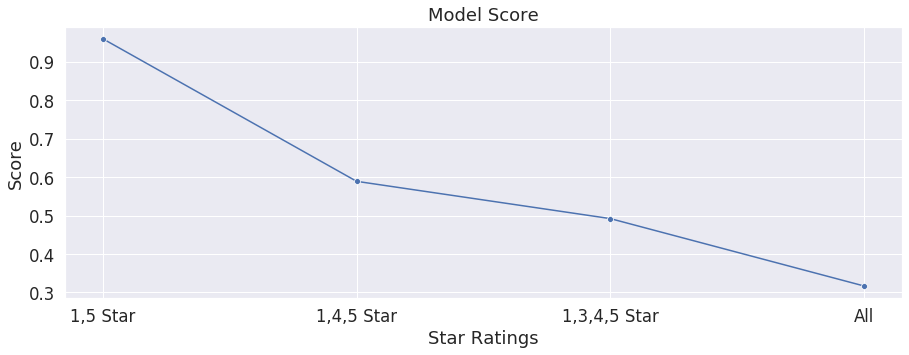

In [7]:
f, a = plt.subplots(1, 1, figsize=(15, 5))
_ = sns.lineplot(report_all.label, report_all.eval_metric, marker="o", sort=False)
_ = a.set_title("Model Score")
_ = a.set_xlabel("Star Ratings")
_ = a.set_ylabel("Score")

# Classification Report

* Recall stays roughly the same across
* Precision drops as we introduce more classes
  * 1-star and 3-star review precision drops pretty quickly as we introduct more classes

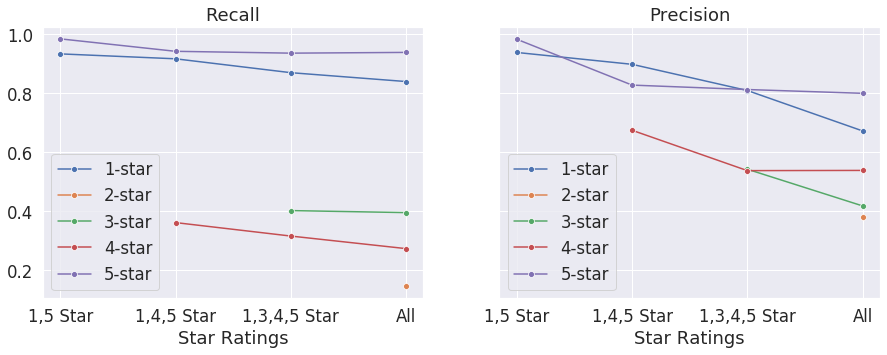

In [8]:
f, a = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.lineplot(report_all.label, report_all["1_recall"], sort=False, label="1-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["2_recall"], sort=False, label="2-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["3_recall"], sort=False, label="3-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["4_recall"], sort=False, label="4-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["5_recall"], sort=False, label="5-star", marker="o", ax=a[0])
_ = a[0].set_xlabel("Star Ratings")
_ = a[0].set_ylabel("")
_ = a[0].set_title("Recall")

sns.lineplot(report_all.label, report_all["1_precision"], sort=False, label="1-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["2_precision"], sort=False, label="2-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["3_precision"], sort=False, label="3-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["4_precision"], sort=False, label="4-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["5_precision"], sort=False, label="5-star", marker="o", ax=a[1])
_ = a[1].set_xlabel("Star Ratings")
_ = a[1].set_ylabel("")
_ = a[1].set_title("Precision")

# Confusion Matrix For Various Runs

## 1-star and 5-star Only

* This is our baseline. We do have some 1-star misclassified as 5-star and vice versa but numbers look pretty reasonable. < 10% for both classes.

In [9]:
pd.DataFrame(json.loads(lstm_15.confusion_matrix.values[0])).rename({0: 1, 1: 5}, axis=1)

,1,5
0,32550,2340
1,2161,131730


## 1-star, 4-star, 5-star

* 1-star most likely misclassified as 5-star
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [10]:
pd.DataFrame(json.loads(lstm_145.confusion_matrix.values[0])).rename({0: 1, 2: 5, 1: 4}, axis=1)

,1,4,5
0,32077,1079,1853
1,2015,14975,24488
2,1646,6165,126011


## 1-star, 3-star, 4-star, 5-star

* 1-star most likely misclassified as 3-star
* <b>3-star most likely misclassified as 4-star (but 1 and 5 are pretty close)</b>
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [11]:
pd.DataFrame(json.loads(lstm_1345.confusion_matrix.values[0])).rename({0: 1, 1: 3, 2: 4, 3: 5}, axis=1)

,1,3,4,5
0,30286,2461,444,1652
1,4608,9151,4710,4311
2,1236,4007,13028,23039
3,1318,1268,6071,125344


## All star ratings

* 1-star most likely misclassified as 3-star
* <b>2-star most likely misclassified as 1-star, 2-star is more likely to be misclassified as 1-star than itself</b>
* <b>3-star most likley misclassified as 5-star, then 4-star and 1-star</b>
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [12]:
pd.DataFrame(json.loads(lstm_all.confusion_matrix.values[0])).rename({0: 1, 1: 2, 2: 3, 3: 4, 4: 5}, axis=1)

,1,2,3,4,5
0,29386,1772,2041,219,1601
1,8135,2428,4045,643,1349
2,3751,1679,8794,3673,4374
3,1132,344,4585,11357,24217
4,1346,144,1599,5223,125584


# Look at Specific Reviews That Are Misclassified

In [13]:
# Read data file - we know they all started with the same data file so let's just pick one to start with
DATA_FILE = lstm_15.file.values[0]
print(f'Reading datafile: {DATA_FILE}')
df = pd.read_csv(DATA_FILE, encoding='utf8', engine='python')

Reading datafile: drive/My Drive/Springboard/capstone/data/amazon_reviews_us_Wireless_v1_00-1m-with_stop_nonlemmatized-preprocessed.csv


# 1-Star and 5-Star Only

In [0]:
MAX_SEQUENCE_LENGTH = 100

def load_and_predict(report: pd.DataFrame, reviews_test):
  """
  :param report: report DF
  :param classes: list of classes to keep
  :return: mode, tokenizer, predictions, unencoded predictions
  """
  print(f'Loading tokenizer file: {report.tokenizer_file.values[0]}')
  with open(report.tokenizer_file.values[0], 'rb') as file:
    t = pickle.load(file)

  # Pre-process our features (review body)
  # t = Tokenizer(oov_token="<UNK>")
  # fit the tokenizer on the documents
  # t.fit_on_texts(reviews_train)
  # tokenize both our training and test data
  test_sequences = t.texts_to_sequences(reviews_test)

  print("Vocabulary size={}".format(len(t.word_counts)))
  print("Number of Documents={}".format(t.document_count))


  # pad our reviews to the max sequence length
  X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

  print('Test review vectors shape:', X_test.shape)

  print(f'Loading model file: {report.model_file.values[0]}')
  model = load_model(report.model_file.values[0])
  print(f'Predicting test set...')
  y_predict = model.predict(X_test)

  print(f'Unencoding predictions...')
  y_predict_unencoded = ku.unencode(y_predict)

  return model, t, y_predict, y_predict_unencoded




### Incorrect Results For 1-Star and 5-Star only

* Unmap predictions to original star ratings
* merge with reviews so we can look at the text

In [15]:
# predict 15
df_15 = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 5)]
# have to set 5's to 2's so we can compute class weights later
df_15.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 2
CLASSES = 2

ratings_15 = df_15[LABEL_COLUMN]
reviews_15 = df_15[REVIEW_COLUMN]

reviews_train_15, reviews_test_15, y_train_15, y_test_15 = train_test_split(reviews_15, ratings_15, random_state=1)

model_15, t_15, y_predict_15, y_predict_unencoded_15 = load_and_predict(lstm_15, reviews_test_15)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove_with_stop_nonlemmatized-sampling_none-675121-100-star_rating-tokenizer.pkl
Vocabulary size=89257
Number of Documents=506340
Test review vectors shape: (168781, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove_with_stop_nonlemmatized-sampling_none-675121-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
def unmap_15(y_unencoded: pd.DataFrame):
  # unmap preidctions 2->5
  y_unencoded.loc[results_15.true_15 == 2, "true_15"] = 5
  y_unencoded.loc[results_15.predict_15 == 2, "predict_15"] = 5
  return y_unencoded


results_15 = pd.DataFrame({"true_15": y_test_15, "predict_15": y_predict_unencoded_15})
unmap_15(results_15)

results_15 = results_15.join(reviews_test_15).reset_index().rename({"index": "index_orig"}, axis=1)


In [17]:
results_15[results_15.true_15 != results_15.predict_15].head(10)

,index_orig,true_15,predict_15,review_body
9,284842,5,1,i have purchased a number of after market chargers and they all eventually fail i am very happy to report that it worked from the get go and keeping my fingers crossed the ubiquitous your phone does not support the is device has not popped up
19,947004,1,5,very misleading this is not an otterbox like i have purchased from the store it does not say otterbox on it it is not made like an otterbox either it is kind of a knock off the clear plastic insterts that cover the camera lenses you have to glue these on yourself it is like performing surgery ca...
30,875542,5,1,the mount works great and looks real nice the wire for it deffinently was a rip off though they also had no wireing diagram so if you cant use a voltmeter wire and mount are kind of worthless
61,528773,5,1,after it was in my drawer for a long ti ame i installed it on my htc and it is not that good all the corners and sides have air in them like a long bubble and also in the bottom left corner the whole protector is turning up so a lot of dust got in there until it sticked it get scratches pretty e...
85,326416,5,1,poor quality
117,587687,5,1,bought them for my workers and they are fine with it nobody report the product is bad not hard to use
154,756433,5,1,love the colors and design of this case i would not recommend the case if you are looking for something that covers the front
178,823493,5,1,cant wait to get my dock extender to try it out just like previous one i bought through apple awesome and cheap but high quality
179,936181,1,5,samsung has left this model out to dry the sprint model already has the new honycomb os update this model no word or care from t mobile or samsung on if the device will ever have the modern software all other devices can use or be left in the dark forever also the front camera does work it might...
193,762066,1,5,front rubber comes out everyone i use the pen why would amazon let this pensell on their website site


In [18]:
reviews_15.iloc[326416]

'worked like a charm for fixing my smashed up phone face my friend did the total replacement for me in under an hour it was his second ti ame going through it the first ti ame he said it took hi am over 2 hours to get the hang of it make a template for where all of the items that you take off go back in place and it will be much easier'

# 1-Star, 4-Star, and 5-Star

In [19]:
# predict 145
df_145 = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 4) | (df[LABEL_COLUMN] == 5)]
# have to set 4->2, 5->3
df_145.loc[df[LABEL_COLUMN] == 4, LABEL_COLUMN] = 2
df_145.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 3

ratings_145 = df_145[LABEL_COLUMN]
reviews_145 = df_145[REVIEW_COLUMN]

reviews_train_145, reviews_test_145, y_train_145, y_test_145 = train_test_split(reviews_145, ratings_145, random_state=1)

model_145, t_145, y_predict_145, y_predict_unencoded_145 = load_and_predict(lstm_145, 
                                                                     reviews_test_145)



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16_145-1x16-glove_with_stop_nonlemmatized-sampling_none-841233-100-star_rating-tokenizer.pkl
Vocabulary size=104958
Number of Documents=630924
Test review vectors shape: (210309, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16_145-1x16-glove_with_stop_nonlemmatized-sampling_none-841233-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
def unmap_145(y_encoded: pd.DataFrame):
  y_encoded.loc[y_encoded.true_145 == 2, "true_145"] = 4
  y_encoded.loc[y_encoded.true_145 == 3, "true_145"] = 5
  y_encoded.loc[y_encoded.predict_145 == 2, "predict_145"] = 4
  y_encoded.loc[y_encoded.predict_145 == 3, "predict_145"] = 5
  return y_encoded


results_145 = pd.DataFrame({"true_145": y_test_145, "predict_145": y_predict_unencoded_145})

# unmap preidctions 2->4, 3->5
# results_145.loc[results_145.true_145 == 2, "true_145"] = 4
# results_145.loc[results_145.true_145 == 3, "true_145"] = 5
# results_145.loc[results_145.predict_145 == 2, "predict_145"] = 4
# results_145.loc[results_145.predict_145 == 3, "predict_145"] = 5
unmap_145(results_145)

results_145 = results_145.join(reviews_test_145).reset_index().rename({"index": "index_orig"}, axis=1)


### Misclassified 1-Star Reviews

In [21]:
results_145[(results_145.true_145 == 1) & 
            (results_145.true_145 != results_145.predict_145)].head(10)

,index_orig,true_145,predict_145,review_body
7,165367,1,5,it is degrees here in florida and the smart watch continuously shows i must say i wish i hope that is was just that one i am checking into the gear live watch maybe that will work for me
160,210353,1,5,what you are seeing on everyone elses review is accurate the sound quality of these headphones is on par with a tin can and a string i bought a pair at the dollar store and chose the brand name over an equally priced competitor that i would never heard of i am regretting my decision i ammensely
237,753082,1,5,update days beyond warranty one year and days after purchase the flip out stand ceased to remain closed the magnet in the stand became detached i stuck it back in but it will not stay in not that seidio would have done anything because they do not stand behind their products even from normal use...
337,267399,1,5,the leather printed with mk is crooked the mk s are running down hill
374,880078,1,4,frustration is the keyword to describe this bluetooth earpiece because it will not stay on my head or in my ear this is not my first bluetooth unit my jabra and motorola have problem free earpieces human ears are certainly rich and varied in size and shape but that is a given not a surprise and ...
480,165662,1,5,way to small for an adult man
586,34964,1,5,does not have built in blue tooth surely this unit does an excellent job as a cd player and plug in usb media player and the package came in good shape all parts included new and clean i bought it specifically for the blue tooth however and was very disappointed
629,746840,1,5,black extreme rugged i ampact armor hybrid hard case cover belt clip holster i bought this item because i needed a belt clip holster for my new i received just a case with a stupid stand no belt clip i buy an item and its not what i even wanted
675,184622,1,5,looks very cheap color was slightly off this is something a teeny bopper would love
684,349748,1,5,1 port usb ok rubber cap good interesting part


### Misclassified 4-Star Reviews

* 4 misclassified as 5

In [22]:
results_145[(results_145.true_145 == 4) & 
            (results_145.predict_145 == 5) & 
            (results_145.true_145 != results_145.predict_145)].head(20)

,index_orig,true_145,predict_145,review_body
2,292311,4,5,works effectively just do not get a cri amp in them
4,569553,4,5,used 2 out of the pack as far as i can tell they do the job would buy again if i did not hate the phone
23,814850,4,5,this is a lovely cellphone case that really protects my phone and it was very affordable i am very pleased with it
26,783777,4,5,bought this case for my i phone 4 and it fits perfect it keeps my phone from getting scratches it is durable
29,280042,4,5,great for phones
30,746017,4,5,i have gotten so many compli aments over this case it is so tiny so it slides easily into my pocket too the shipping was fast just be careful not to be a person dropping around your phone a lot plastic clip ons are more for looks
57,623423,4,5,this battery is amazing cannot kill it all day now no matter what i do back cover is not perfect but it is not as bad as everyone here clai ams the only problem i had is that the power button was being constantly pressed i had to fix that myself other than that best 7 spend ever finally i can ac...
60,345057,4,5,works well grandson very pleased with product exceeds expectations
62,448612,4,5,these are helpful plenty in a package at a good price not as sticky as you would like though
64,450524,4,5,this is a very nice case it fits the iphone 6 perfectly and does add bulk to the phone the only issue is if you want to place the phone on it is face lets say on a table i would not do that the edges of the case do not have enough thickness to keep the phones face from being scratched by somethi...


* 4 misclassified as 1

In [23]:
results_145[(results_145.true_145 == 4) & 
            (results_145.predict_145 == 1) & 
            (results_145.true_145 != results_145.predict_145)].head(10)

,index_orig,true_145,predict_145,review_body
77,204145,4,1,does not fit ulti amate phone
109,943114,4,1,everything pictured arrived exactly as seen it is been almost a year i think or more since my purchase and the screen guard has remained in place despite the fact that it does not initially fit correctly the small cylindrical shaped hole used for the ear speaker at the top was actually placed to...
128,892926,4,1,i received this charger in the mail and i ammediately plugged it in to charge the battery it came with however much to my chagrin the lights would come on and flash between amber and green then shut off thinking that the battery might be bad i tried it in my phone i was unable to even power up t...
331,259822,4,1,only 4 start every thing ok why no battery came with
358,842844,4,1,bought for my senior parents to keep in car hoping they will use it if they get lost disoriented or have car failure phone emits beep when turned on then emergency button can be pushed and is dialed automatically phone emits a signal when the off button is pressed should be easy for them to use
417,705184,4,1,i wish this mount were twice as stiff and about three ti ames as long as it is it will only put your phone about lap level which is not safe to drive with i crafted my own extension and from there had a workable solution
424,429481,4,1,looks cute but hard to push the buttons on the side through the case get what you pay for i guess
749,716800,4,1,when you put the phone in the holster you cannot charge it you have to put the phone in upside down so the charging port is up other than that it is pretty good
855,865437,4,1,didnt really think much of the gold ri amming doesnt look so flashy in the picture leather pattern is also kinda plasticy but i really like the design which is why i bought it and its just bucks too
1130,336317,4,1,i wore this case for 3 months straight and it turned white at the edges and it started chipping and etc


# 1-Star, 3-Star, 4-Star, 5-Star Ratings

In [24]:
# predict 1345
df_1345 = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 3) | (df[LABEL_COLUMN] == 4) | (df[LABEL_COLUMN] == 5)]
# have to set 3->2, 4->3, 5->4
df_1345.loc[df[LABEL_COLUMN] == 3, LABEL_COLUMN] = 2
df_1345.loc[df[LABEL_COLUMN] == 4, LABEL_COLUMN] = 3
df_1345.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 4

ratings_1345 = df_1345[LABEL_COLUMN]
reviews_1345 = df_1345[REVIEW_COLUMN]

reviews_train_1345, reviews_test_1345, y_train_1345, y_test_1345 = train_test_split(reviews_1345, ratings_1345, random_state=1)

model_1345, t_1345, y_predict_1345, y_predict_unencoded_1345 = load_and_predict(lstm_1345, 
                                                                     reviews_test_1345)



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16_1345-1x16-glove_with_stop_nonlemmatized-sampling_none-931734-100-star_rating-tokenizer.pkl
Vocabulary size=111768
Number of Documents=698800
Test review vectors shape: (232934, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16_1345-1x16-glove_with_stop_nonlemmatized-sampling_none-931734-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
def unmap_1345(y_encoded: pd.DataFrame):
  # unmap preidctions 2->3, 3->4, 4->5

  y_encoded.loc[y_encoded.true_1345 == 4, "true_1345"] = 5
  y_encoded.loc[y_encoded.true_1345 == 3, "true_1345"] = 4
  y_encoded.loc[y_encoded.true_1345 == 2, "true_1345"] = 3
  y_encoded.loc[y_encoded.predict_1345 == 4, "predict_1345"] = 5
  y_encoded.loc[y_encoded.predict_1345 == 3, "predict_1345"] = 4
  y_encoded.loc[y_encoded.predict_1345 == 2, "predict_1345"] = 3
  return y_encoded


results_1345 = pd.DataFrame({"true_1345": y_test_1345, "predict_1345": y_predict_unencoded_1345})

# results_1345.loc[results_1345.true_1345 == 4, "true_1345"] = 5
# results_1345.loc[results_1345.true_1345 == 3, "true_1345"] = 4
# results_1345.loc[results_1345.true_1345 == 2, "true_1345"] = 3
# results_1345.loc[results_1345.predict_1345 == 4, "predict_1345"] = 5
# results_1345.loc[results_1345.predict_1345 == 3, "predict_1345"] = 4
# results_1345.loc[results_1345.predict_1345 == 2, "predict_1345"] = 3
unmap_1345(results_1345)

results_1345 = results_1345.join(reviews_test_1345).reset_index().rename({"index": "index_orig"}, axis=1)

### Misclassified 3-Star Reviews

* 3 as 4

In [26]:
results_1345[(results_1345.true_1345 == 3) & 
            (results_1345.predict_1345 == 4) & 
             (results_1345.true_1345 != results_1345.predict_1345)].head(10)

,index_orig,true_1345,predict_1345,review_body
53,423802,3,4,looks and feels amazing only gripe is that a few days in the edges started chipping i recommend using this with a case of your going buy so it can protect the edges
117,822267,3,4,i do not drop my phones or treat them like a toy but it did start to peel on the back after purchase
134,768691,3,4,it is a good case but to big for my samsung galaxyit arrived on ti ame but i can t really use it
205,648701,3,4,it looks just like the picture and for cents you get exactly what you pay for cheap plastic that breaks the first ti ame you drop it
213,65178,3,4,the concept for this case is amazing it looks cool and i have received several compli aments on it however an air bubble appeared within two days of putting the case on the small air bubble has slowly become worse but it is still a decent case
351,863654,3,4,my daughter loves the color but she cannot use her ipod very well with the front cover she has a hard ti ame selecting songs because the cover is over the controls as well
410,743767,3,4,the lip surrounding the longer sides of the screen is not raised much at all so i am concerned that if phone drops flat on the screen or on an uneven surface for example gravel there is a possibility the screen will scratch or crack along with others i would recommend a screen protector as a mus...
450,662888,3,4,as cases go this is not too bad i generally use an otterbox defender while i think the otterbox is far superior for protecting the phone i have used cases like this the mostly protect the back of the phone while leaving the screen open the cost of more protection is the bulk it adds to the size ...
478,648906,3,4,i like this cover because its interesting looking and it actually does a pretty good job of prodecting my phone i am a person who tends to drop my phone and it has not shattered or broken yet the only thing about this case is that the front part when you put it together tends to get caught on th...
522,63147,3,4,very loose replacement functions perfectly well but its easy to come off


* 3 as 1

In [27]:
results_1345[(results_1345.true_1345 == 3) & 
            (results_1345.predict_1345 == 1) & 
             (results_1345.true_1345 != results_1345.predict_1345)].head(10)

,index_orig,true_1345,predict_1345,review_body
3,479273,3,1,very cheaply made do not last long
194,738261,3,1,was a good product and had me relying on it more and more unfortunately after 2 months of use it stopped working it will not charge up or give charge no leds nothing customer support was willing to give me a new one in exchange of the old one but i am on vacationing abroad this summer which mean...
306,522951,3,1,when you are listening to the radio and switch to the fm transmitter for a 3 device the volume is not as loud plus the batteries that come with it dont last long at all
322,870011,3,1,nice price good looks i cannot get the bluetooth to work streaming nor phonecalls no idea samsung galaxy s says it is paired pairing worked fine unit tells me nothing i am the only one using a galaxy s this is a very confusing unit menus are confusing i cannot even figure out if the bluetooth is...
327,617054,3,1,it was tough to use as the clamp that holds the phone was not well shaped and barely opened wide enough to fit the phone my i ampression is that this designed for a generic cellphone and not specifically for the fairly large galaxy note phones i ulti amately gave it away to someone else with a m...
357,982415,3,1,i thought since these radios cost a little more than what we had been using they would be awesome i do not know if it is because our building is concrete or what but someti ames messages do not go through to all radios also the cheap ear pieces pretty much all snapped in the same place two days ...
443,733237,3,1,if you drop your phone slot this case is not for you mine has been on for two days and is cracked and i did not drop it
503,108629,3,1,the clip broke the same day
514,931723,3,1,the case looks very stylish i love the design but the physical construction leaves a bit to be desired the plastic band that fits around the iphone is a little fli amsy especially on the bottom around the usb connector port the plastic is very thin and breaks easy the first ti ame i put it aroun...
525,892843,3,1,i received this case about a month ago it is a very nice looking case and love the feel of it i have also received many compli aments on it however just a few days ago all the edges started peeling off for no reason my phone never gets wet and i take very good care of it even with a case on this...


# All Star Ratings

In [28]:
ratings_all = df[LABEL_COLUMN]
reviews_all = df[REVIEW_COLUMN]

reviews_train_all, reviews_test_all, y_train_all, y_test_all = train_test_split(reviews_all, ratings_all, random_state=1)

model_all, t_all, y_predict_all, y_predict_unencoded_all = load_and_predict(lstm_all, 
                                                                     reviews_test_all)



Loading tokenizer file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-glove_with_stop_nonlemmatized-sampling_none-997682-100-star_rating-tokenizer.pkl
Vocabulary size=116983
Number of Documents=748261
Test review vectors shape: (249421, 100)
Loading model file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-glove_with_stop_nonlemmatized-sampling_none-997682-100-star_rating-model.h5
Predicting test set...
Unencoding predictions...


In [0]:
results_all = pd.DataFrame({"true_all": y_test_all, "predict_all": y_predict_unencoded_all})

# don't have to unmap predictions

results_all = results_all.join(reviews_test_all).reset_index().rename({"index": "index_orig"}, axis=1)

In [30]:
results_all[results_all.index_orig == 629436]

,index_orig,true_all,predict_all,review_body


### Misclassified Samples

* 1 as 5

In [31]:
results_all[(results_all.true_all == 1) & 
            (results_all.predict_all == 5) & 
             (results_all.true_all != results_all.predict_all)].head(10)

,index_orig,true_all,predict_all,review_body
82,732849,1,5,fully extended or at least as far as i could get it to go it still only measured a little more than a foot long the cord when retracted twisted up on both sides and i had to struggle with it to make it retract fully and for all that trouble it worked only one ti ame do not bother with this one
422,872381,1,5,i knew what i was getting before i ordered but that was based solely on the first two product reviews not on the official product description it appears to be about 5 gauge wire not 4 the wire diameter is approxi amately inches here are the official awg wire sizes for reference 4 awg gauge 5 awg...
596,800238,1,5,my husband tried all three and all three had to be trashed tried a pricey screen cover and no problems he had it on in less than a minute will not but these again
614,908098,1,5,i have yet to receive this order i realize it is coming from hong kong but it has been about 5 weeks since the order
739,967529,1,5,this comes up in the search for skins cases and covers for your blackberry read the fine print it is a set of stickers and they charge 5 in shipping for something should ship in an envelope for 0
792,931138,1,5,the stones fell of in the plastic they were also made of plastic and lacked luster the good news is that when i wrote my first review the company refunded my money yeah
808,586211,1,5,i ordered this pouch to carry my samsung note 3 around my neck but got a totally different style one i would never have picked the measurements shown are smaller than described will not fit my note 3 with the otterbox i took a good deal of ti ame looking for something large enough for the phone ...
836,627372,1,5,was not the correct size loved the case just what i wanted but to small all the rest ordered worked perfect
853,297393,1,5,i have problems they send me us staff i was order new
933,788903,1,5,me estafaron jueves pague un envio rapido me cobraron pasaron 5 dias y todavia no llego se me va el vuelo y no tengo el telefono muy desconformetengo que molestar vecinos devuelvanme el dinero de mi envio


# Join all Results Dataframe Into One

In [32]:
results_comprehensive = pd.merge(pd.merge(pd.merge(results_15.drop(["review_body", "true_15"], axis=1), 
                                                results_145.drop(["review_body", "true_145"], axis=1), how='outer', 
                                                left_on="index_orig", right_on="index_orig"),
                                      results_1345.drop(["review_body", "true_1345"], axis=1), how='outer', 
                                                left_on="index_orig", right_on="index_orig"),
                                      results_all, how='outer', 
                                                left_on="index_orig", right_on="index_orig")

results_comprehensive = results_comprehensive.dropna(subset=["review_body"])
results_comprehensive.head()



,index_orig,predict_15,predict_145,predict_1345,true_all,predict_all,review_body
6,567377,5.0,NaN,NaN,5.0,5.0,i love these connectors they take a lot of the hassle of splicing stereo wires together i am very glad i found these on amazon
10,494240,5.0,NaN,NaN,5.0,5.0,fast shipping great price
12,309913,1.0,NaN,1.0,1.0,1.0,did not fit the phone
14,333089,5.0,5.0,NaN,5.0,5.0,i love this case compact and efficient nice leather
15,450253,5.0,NaN,NaN,5.0,5.0,future project


## Add Column for Out of Vocab Words

In [44]:
EMBEDDING_INDEX_FILE = f'{DRIVE_DIR}/models/glove.840B.300d-embedding_index'

embeddings_index = {}

if os.path.exists(f'{EMBEDDING_INDEX_FILE}.npy'):
  print(f'Loading {EMBEDDING_INDEX_FILE}.npy')
  embeddings_index = np.load(f'{EMBEDDING_INDEX_FILE}.npy', 
                             allow_pickle = True).item()
else:
  print('Indexing word vectors.')

  with open(EMBEDDING_FILE) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  np.save(EMBEDDING_INDEX_FILE, embeddings_index)

print(type(embeddings_index))
print(np.shape(embeddings_index))
print('Found %s word vectors.' % len(embeddings_index))

Loading drive/My Drive/Springboard/capstone/models/glove.840B.300d-embedding_index.npy
<class 'dict'>
()
Found 2195884 word vectors.


In [63]:
import os

results_comprehensive_file = f'{DRIVE_DIR}/reports/5.1-LSTM-misclassification-analysis-results_comprehensive.csv'

if os.path.exists(results_comprehensive_file) and not FORCE_LOAD:
  results_comprehensive = pd.read_csv(results_comprehensive_file)
else:
  total_count = len(results_comprehensive)
  count = 0
  for index, row in results_comprehensive.iterrows():
    review_body = row.review_body
    review_body_word_list = review_body.split()
    review_body_wc = len(review_body_word_list)
    missing_words = {word for word in review_body_word_list if word not in embeddings_index.keys()}
    training_text = [word for word in review_body_word_list if word in embeddings_index.keys()]
    if len(missing_words) > 0:
      results_comprehensive.loc[index, "out_of_vocab"] = " ".join(missing_words)
      results_comprehensive.loc[index, "review_body_train"] = " ".join(training_text[:review_body_wc - len(missing_words)])
    else:
      results_comprehensive.loc[index, "review_body_train"] = " ".join(review_body_word_list[:min(review_body_wc, MAX_SEQUENCE_LENGTH)])
    
    count += 1
    if count % 10000:
      print(f'Processing {count} of {total_count}')

  print(f'Saving to {results_comprehensive_file}...')
  results_comprehensive.to_csv(results_comprehensive_file, index=False)

results_comprehensive.head(20)

,index_orig,predict_15,predict_145,predict_1345,true_all,predict_all,review_body,out_of_vocab,review_body_train
6,567377,5.0,NaN,NaN,5.0,5.0,i love these connectors they take a lot of the hassle of splicing stereo wires together i am very glad i found these on amazon,NaN,i love these connectors they take a lot of the hassle of splicing stereo wires together i am very glad i found these on amazon
10,494240,5.0,NaN,NaN,5.0,5.0,fast shipping great price,NaN,fast shipping great price
12,309913,1.0,NaN,1.0,1.0,1.0,did not fit the phone,NaN,did not fit the phone
14,333089,5.0,5.0,NaN,5.0,5.0,i love this case compact and efficient nice leather,NaN,i love this case compact and efficient nice leather
15,450253,5.0,NaN,NaN,5.0,5.0,future project,NaN,future project
30,875542,1.0,NaN,NaN,5.0,5.0,the mount works great and looks real nice the wire for it deffinently was a rip off though they also had no wireing diagram so if you cant use a voltmeter wire and mount are kind of worthless,NaN,the mount works great and looks real nice the wire for it deffinently was a rip off though they also had no wireing diagram so if you cant use a voltmeter wire and mount are kind of worthless
34,447088,5.0,NaN,NaN,5.0,5.0,review for the alixo s iphone 6 case ive been using the alixo case for a few days now so it is ti ame to post my pros and possibly a con i will start with the con of the case and first off the case comes in two pieces front and back and both pieces are hard the inside being harder than the outsi...,seenthe alixo sensordirt prosincludes,review for the s iphone 6 case ive been using the case for a few days now so it is ti ame to post my pros and possibly a con i will start with the con of the case and first off the case comes in two pieces front and back and both pieces are hard the inside being harder than the outside so i am n...
39,343036,1.0,NaN,NaN,1.0,1.0,this does not work on most phones with an otterbox defender case,NaN,this does not work on most phones with an otterbox defender case
43,674249,5.0,NaN,NaN,5.0,5.0,looks fancy but it is economical it does not look cheap at all must have if you have a samsung galaxy note 2 make sure not to lose it because you will lose your phone credit cards and drivers license all together,NaN,looks fancy but it is economical it does not look cheap at all must have if you have a samsung galaxy note 2 make sure not to lose it because you will lose your phone credit cards and drivers license all together
44,724688,1.0,NaN,1.0,1.0,1.0,the picture that is on amazon com is not what i received i received a pin female to micro usb 5 pin male charger what is on the picture is a pin female to mini usb 5 pin male charger,NaN,the picture that is on amazon com is not what i received i received a pin female to micro usb 5 pin male charger what is on the picture is a pin female to mini usb 5 pin male charger


## Aggregate common reviews that were in various runs of our models

* 2k 5-star samples that were in all runs
* 2.6k 4-star samples that were in all relevant runs
* 5.6k 3-star samples
* 16k 2-star samples
* 570 1-star samples

In [64]:
results_5 = results_comprehensive[(results_comprehensive.true_all == 5) &
                      results_comprehensive.predict_15.notnull() &
                      results_comprehensive.predict_145.notnull() &
                      results_comprehensive.predict_1345.notnull()]
print(f'5-star shape: {results_5.shape}')

results_4 = results_comprehensive[(results_comprehensive.true_all == 4) &
                      results_comprehensive.predict_145.notnull() &
                      results_comprehensive.predict_1345.notnull()]
print(f'4-star shape: {results_4.shape}')

results_3 = results_comprehensive[(results_comprehensive.true_all == 3) &
                      results_comprehensive.predict_1345.notnull()]
print(f'3-star shape: {results_3.shape}')

results_2 = results_comprehensive[(results_comprehensive.true_all == 2)]
print(f'2-star shape: {results_2.shape}')

results_1 = results_comprehensive[(results_comprehensive.true_all == 1) &
                      results_comprehensive.predict_15.notnull() &
                      results_comprehensive.predict_145.notnull() &
                      results_comprehensive.predict_1345.notnull()]
print(f'1-star shape: {results_1.shape}')

5-star shape: (1976, 9)
4-star shape: (2583, 9)
3-star shape: (5668, 9)
2-star shape: (16600, 9)
1-star shape: (570, 9)


<a id='model-debugging'></a>
# Debugging The Model




### 4-Star Reviews That Were Misclassified as 5

Our theory is that for 4-star reviews, the model is not correcting negative context correctly. We will pick a couple reviews that have clear negative fragments and run the through the model and look at their probabilities

In [73]:
results_4[(results_4.predict_145 == 5) |
          (results_4.predict_1345 == 5) |
          (results_4.predict_all == 5)][["index_orig", "true_all", "predict_145", "predict_1345", "review_body", "out_of_vocab"]].sample(20, random_state=3)

,index_orig,true_all,predict_145,predict_1345,review_body,out_of_vocab
270595,958840,4.0,5.0,5.0,okay so i read a gazillion reviews before purchasing these bluetooth headphones i heard a lot of bad and i heard a lot of good keep in mind that i have only had these for a day or so and will update if things change pros i do not know what people are talking about i have the iphone 4 with the ne...,NaN
245208,846885,4.0,5.0,5.0,military family stationed overseas and ordered this for a trip back stateside got to our apo quickly despite the mail lag from storm sandy and was easy to activate google activate si am with zeroes i amei thanks and a for service quality value,NaN
205184,298675,4.0,5.0,5.0,the case feels great in the hand and i feels very natural it looks adorable and was easy to install it fixes my problem with my previous case which was that i had to take my case off to charge my phone this phone has a good sized acess port for charging however i am the most accident prone human...,NaN
270356,851267,4.0,5.0,5.0,have to say this thing is what i thought it would be not the best internet but on my it gets the job done,NaN
201795,59863,4.0,5.0,5.0,arrived faster than i thought it would fit the phone perfectly,NaN
262241,793327,4.0,5.0,4.0,what a great cover it reminds me of the old days only issue i have with this item is that its slightly too large but not enough to keep off my iphone,NaN
183496,536569,4.0,5.0,5.0,really give it a 4 5 so far i have really enjoyed the i previously purchased three of the original li ameade and still use and was very satisfied with that product i have been using this unit daily for the past few weeks nothing has been a deal breaker but there are a couple of small things tobe...,ameade ameblast ofpros
175822,145305,4.0,4.0,3.0,it is beautiful but fragil,NaN
286565,20890,4.0,5.0,5.0,it is better than i expected not fli amsy and really fits my phone,amsy
309219,795326,4.0,5.0,5.0,very good product installed it and wow the bass from such a little amp but that is polk audio i had heard this exact amp in a jeep grand cheeroke and it was pushing 3 ten inch woofer amazing how technology has evolved i used to have a orion great amp but just to big but it was amazing also this ...,cheeroke


#### Edit Review and see if it detects negative

The following review has a negative (original index: 851267) - let's see if the model detects this: "have to say this thing is what i thought it would be not the best internet but on my it gets the job done" the model is not detecting **not the best** as a negative

Probability for star ratings:

* entire review - 60% 5-star, 38% 4-star
* have to say this thing is what i thought it would be - 80% 5-star 
* gets the job done - 64% 5-star, 36% 4-star
* not the best internet - 77% 1-star
* not the best internet but on my gets the job done - 69% 4-star


In [69]:
# 406428 - this is a good case just not as protective as some of the others it 
#           keeps the sli am look and fits in my purse better than the bulky cases
# cleaned up review - this is a good case 
#           it keeps the sli am look and fits in my purse better 
#           than the bulky cases
review_temp = [reviews_145.loc[851267],
               'have to say this thing is what i thought it would be',
               'gets the job done', 
               'not the best internet',
               'not the best internet but on my gets the job done',
               ]

# train both using 145 model
sequences_temp = t_145.texts_to_sequences(review_temp)

# pad our reviews to the max sequence length
X_temp = sequence.pad_sequences(sequences_temp, maxlen=MAX_SEQUENCE_LENGTH)

print('Test review vectors shape:', X_temp.shape)

print(f'Predicting test set...')
y_predict_temp = model_145.predict(X_temp)
y_predict_unencoded_temp = ku.unencode(y_predict_temp)

# unmap predictions
y_predict_unencoded_temp[y_predict_unencoded_temp == 3] = 5

print(y_predict_temp)
print(y_predict_unencoded_temp)



Test review vectors shape: (5, 100)
Predicting test set...
[[0.02217765 0.37673366 0.60108864]
 [0.03176164 0.16336995 0.8048684 ]
 [0.00186574 0.3592106  0.6389236 ]
 [0.77564967 0.06021775 0.16413254]
 [0.05728094 0.6886509  0.25406817]]
[5, 3, 3, 1, 2]


Original Index: 338372

Review: i like this screen protector as the installation was easy enough there is only one bubble on it which annoys me but it looks good nonetheless	

Probability for Star Ratings:

| text | 1-star prob | 4-star prob | 5-star prob | notes |
|------|-------------|-------------|-------------|-------|
| full reviews | 0% | 36% | 64% | |
| i like this screen protector as the installation was easy enough | 1.4% | 19% | 80% | |
| there is only one bubble on it which annoys me | 55% | 14% | 31% | |
| it looks good | 0.3% | 35% | 65% | |
| but it looks good | 0.4% | 71% | 29% | adding but drops the class to 4-stars |
| i like this screen protector as the installation was easy enough there is only one bubble on it which annoys me | 0.4% | 29% | 71% | when mixed with a positive fragment, the negative fragement </br> does not bring down the probability for 5-star review enough |
| there is only one bubble on it which annoys me but it looks good | .8% | 65% | 35% | |
| but | 17% | 57% | 26% | model does attribute but as a negative |
| like | .3% | 30% | 67% | |
| easy | 1.5% | 27% | 71% | |

In [88]:

# full review: i like this screen protector as the 
# installation was easy enough there is only one bubble on it 
# which annoys me but it looks good nonetheless
review_temp = [reviews_145.loc[338372],
               'i like this screen protector as the installation was easy enough',
               'there is only one bubble on it which annoys me', 
               'it looks good',
               'but it looks good',
               'i like this screen protector as the installation was easy enough there is only one bubble on it which annoys me',
               'there is only one bubble on it which annoys me but it looks good',
               'but',
               'like',
               'easy'
               ]

# train both using 145 model
sequences_temp = t_145.texts_to_sequences(review_temp)

# pad our reviews to the max sequence length
X_temp = sequence.pad_sequences(sequences_temp, maxlen=MAX_SEQUENCE_LENGTH)

print('Test review vectors shape:', X_temp.shape)

print(f'Predicting test set...')
y_predict_temp = model_145.predict(X_temp)
y_predict_unencoded_temp = ku.unencode(y_predict_temp)

# unmap predictions
y_predict_unencoded_temp[y_predict_unencoded_temp == 3] = 5

print(y_predict_temp)
print(y_predict_unencoded_temp)

Test review vectors shape: (10, 100)
Predicting test set...
[[6.1976153e-04 3.6378387e-01 6.3559645e-01]
 [1.4228715e-03 1.9989388e-01 7.9868329e-01]
 [5.5278003e-01 1.3719454e-01 3.1002536e-01]
 [2.8627028e-03 3.4625372e-01 6.5088362e-01]
 [4.1445233e-03 7.0925033e-01 2.8660515e-01]
 [4.0471260e-03 2.8821608e-01 7.0773679e-01]
 [7.6065003e-03 6.4681494e-01 3.4557858e-01]
 [1.6839622e-01 5.7011735e-01 2.6148644e-01]
 [3.1544831e-02 3.0229831e-01 6.6615683e-01]
 [1.5321432e-02 2.7683428e-01 7.0784432e-01]]
[5, 3, 1, 3, 2, 3, 2, 2, 3, 3]


# 5-Star that were correctly classified as 5-stars but misclassified as 4-star once we introduct 4-star reviews

In [80]:
results_5[(results_5.true_all == 5) &
          (results_5.predict_15 == 5) &
          (results_5.predict_145 != 5) &
          (results_5.predict_1345.notnull()) &
          (results_5.predict_all.notnull())][["index_orig", "true_all", "predict_145", "predict_1345", "predict_all", "review_body", "out_of_vocab"]].sample(10, random_state=1)

,index_orig,true_all,predict_145,predict_1345,predict_all,review_body,out_of_vocab
138584,14214,5.0,4.0,4.0,3.0,i like it but it had quirks however after letting hisbox know of my difficulty they requested that i return their hi ambox and quickly replaced it with a new unit subsequently i have not encountered any problems and recd superior customer support,ambox hisbox
81101,989310,5.0,4.0,4.0,4.0,2 miles into a summer driving trip our new has transformed our route planning swept away the challenges of navigating unfamiliar territory and unexpected detours and has made exploring side roads enjoyable the user interface is very well executed with lots of convenience at your fingertips it re...,amperfect amportance relegetes
95527,969355,5.0,4.0,4.0,4.0,does what is is supposed to do be careful some underpowered usb ports will not work correctly but overall a very good purchase,NaN
126540,78447,5.0,4.0,4.0,4.0,honestly love this case the only complaint would be that the film that you gotta tear off is annoying to get off but hey at least that means it is protected well,NaN
114014,802285,5.0,4.0,5.0,4.0,color matches the picture a little slicker than i envisioned but great fit now when my kids drop the phone the case will not pop apart like non silicone,NaN
153273,329502,5.0,4.0,4.0,5.0,must have for techies all the basic stuff for phone tablet and laptop disassembly the drivers could be better made but no top quality manufacturer is going to challenge apples proprietary pentalobe it is a good quality kit for a great price hence my 5 star rating,NaN
147751,482879,5.0,4.0,5.0,4.0,could not figure out the vent attachment but others are great,NaN
98281,798564,5.0,4.0,5.0,4.0,i love this case it looks cool even though it is not as bright of a purple as the picture shows other reviews said it was kind of hard to put on but i did not have any trouble you just have to put both pieces on at the same ti ame i have only been using it for a week but it seems very durable be...,NaN
70306,949808,5.0,4.0,5.0,5.0,for i thought why not try it you could not find a better deal for these type of headphones opened the box read the instructions and paired the headphones with my iphone 4 flawlessly just make sure you read the instructions on how to pair the device because the lights have to blink red and blue i...,NaN
72039,866424,5.0,4.0,3.0,3.0,i got this specifically for the macro lens and while it does work rather incredibly the range is extremely li amited you literally have to be within 1 2 of what you are photographing and then the field of depth is also very very small you can take close ups of parts of flowers but not the whole ...,amited ampossible


In [86]:
print(results_5[results_5.index_orig == 329502].review_body_train.values[0])

must have for techies all the basic stuff for phone tablet and laptop disassembly the drivers could be better made but no top quality manufacturer is going to challenge apples proprietary pentalobe it is a good quality kit for a great price hence my 5 star rating


Probability for various star ratings

| Reviews | 1-star Prob | 4-star Prob | 5-star Prob | Notes |
|---------|-------------|-------------|-------------|-------| 
| entire review | 23% | 61% | 15% | |
| must have for techies all the basic stuff for phone tablet and laptop disassembly | 4% | 24% | 72% | |
| **the drivers could be better made** | 23% | 31% | **46%** | would probably classify this as 3 or 4 |
| **but no top quality manufacturer is going to challenge apples proprietary pentalobe** | **96%** | 3% | 0.5% | confused positive with a negative |
| it is a good quality kit for a great price hence my 5 star rating | 0.1% | 16% | 84% | |

Looks like the model is probably mis-classifying 2 fragments of the sentence



In [87]:

# full review: i like this screen protector as the 
# installation was easy enough there is only one bubble on it 
# which annoys me but it looks good nonetheless
review_temp = [results_5[results_5.index_orig == 329502].review_body.values[0],
               'must have for techies all the basic stuff for phone tablet and laptop disassembly',
               'the drivers could be better made',
               'but no top quality manufacturer is going to challenge apples proprietary pentalobe',
               'it is a good quality kit for a great price hence my 5 star rating'
               ]

# train both using 145 model
sequences_temp = t_145.texts_to_sequences(review_temp)

# pad our reviews to the max sequence length
X_temp = sequence.pad_sequences(sequences_temp, maxlen=MAX_SEQUENCE_LENGTH)

print('Test review vectors shape:', X_temp.shape)

print(f'Predicting test set...')
y_predict_temp = model_145.predict(X_temp)
y_predict_unencoded_temp = ku.unencode(y_predict_temp)

# unmap predictions
y_predict_unencoded_temp[y_predict_unencoded_temp == 3] = 5

print(y_predict_temp)
print(y_predict_unencoded_temp)

Test review vectors shape: (5, 100)
Predicting test set...
[[0.23874527 0.61447966 0.14677505]
 [0.04357148 0.23882134 0.71760714]
 [0.23128337 0.30988884 0.4588278 ]
 [0.96015    0.03460958 0.00524042]
 [0.00169701 0.15537992 0.842923  ]]
[5, 3, 3, 1, 3]


In [43]:
print(datetime.now())

2020-02-23 21:27:02.185542
